# Naive representation

*First pipeline:*
* **1. Data preparation (correlation step):**
    * 1.1 image initialization (spatial domain)
    * 1.2 Fourier transform (frequency domain)
    
    &rarr; simulates radio visibility data
* **2. Data embedding (calibration step):**
    * 2.1 data pre-processing
    * 2.2 data encoding
    
    &rarr; embeds visibilities into qubits
* **3. Data reading (imaging step):**
    * 3.1 readout
    * 3.2 inverse Fourier transform (spatial domain) - IFT
    
    &rarr; approximates science-ready intermediate product  

*Second pipeline:*
* **1. Data preparation (correlation step):**
     * 1.1 image initialization (spatial domain)
     * 1.2 Fourier transform (frequency domain)
     
     &rarr; simulates radio visibility data
* **2. Data embedding (calibration step):**
    * 2.1 data pre-processing
    * 2.2 data encoding
    * 2.3 quantum inverse Fourier transform - QFT
    
    &rarr; embeds visibilities into qubits and applies QFT on qubits
* **3. Data reading (imaging step):**
    * 3.1 readout
    
    &rarr; approximates science-ready intermediate product  

*Digital encoding (binary):*

* circuit family #1 from [Cortese 2018](https://arxiv.org/abs/1803.01958)
* to many features to simulate for PennyLane's implementation - Basis embedding ([Teamplates](https://docs.pennylane.ai/en/stable/introduction/templates.html))

#### Prerequisites

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import struct

import qiskit
from qiskit import *

In [6]:
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram

# Use Aer's AerSimulator
simulator = AerSimulator()

# Create a Quantum Circuit acting on the q register
circuit = QuantumCircuit(2, 2)

# Add a H gate on qubit 0
circuit.h(0)

# Add a CX (CNOT) gate on control qubit 0 and target qubit 1
circuit.cx(0, 1)

# Map the quantum measurement to the classical bits
circuit.measure([0, 1], [0, 1])

# Compile the circuit for the support instruction set (basis_gates)
# and topology (coupling_map) of the backend
compiled_circuit = transpile(circuit, simulator)

# Execute the circuit on the aer simulator
job = simulator.run(compiled_circuit, shots=2000)

# Grab results from the job
result = job.result()

# Returns counts
counts = result.get_counts(compiled_circuit)
print("\nTotal count for 00 and 11 are:", counts)

# Draw the circuit
circuit.draw()


Total count for 00 and 11 are: {'11': 976, '00': 1024}


┌───┐     ┌─┐   
q_0: ┤ H ├──■──┤M├───
     └───┘┌─┴─┐└╥┘┌─┐
q_1: ─────┤ X ├─╫─┤M├
          └───┘ ║ └╥┘
c: 2/═══════════╩══╩═
                0  1

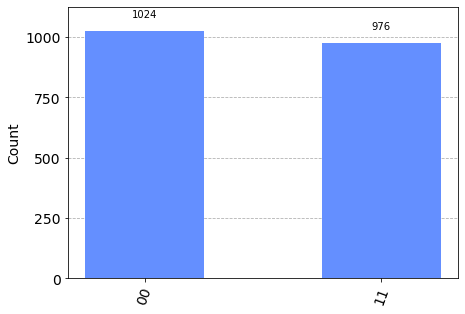

In [7]:
# Plot a histogram
plot_histogram(counts)

In [2]:
# float to binary 
def float_to_bin_real(num):
    return format(struct.unpack('!I', struct.pack('!f', num))[0], '032b')
def float_to_bin_imag(num):
    return format(struct.unpack('!I', struct.pack('!f', num))[0], '032b')

# binary to float
def bin_to_float_real(binary):
    return struct.unpack('!f',struct.pack('!I', int(binary, 2)))[0]
def bin_to_float_imag(binary):
    return struct.unpack('!f',struct.pack('!I', int(binary, 2)))[0]

# reverse a string (for the measurement step readout)
def reverse(string):
    string = string[::-1]
    return string

## 1. Data preparation (correlation step)

### 1.1 image initialization (spatial domain)

In [3]:
# image of the sky filled with double precision complex floats (single precision for reals/imaginaries)
# few pixels are set to relatively large complex random values in random spots (image sources)
# relatively small complex values are added (white noise from background radiations) 

n = 10 #number of antennas

sky_image = np.zeros((n, n), dtype='complex64')
mask = np.zeros((n, n), dtype='bool')
stars = np.random.randint(1, 11) #random number of sources
radius = 1 #np.random.randint(1, 3) #with random radius

for i in range(0, stars):
    index_i = np.random.randint(0, sky_image.shape[0]-radius)
    index_j = np.random.randint(0, sky_image.shape[1]-radius)
    for j in range(0, radius):
        for k in range(0, radius):
            sky_image[index_i+j][index_j+k] = complex(np.random.rand()*100, np.random.rand()*100)
            mask[index_i+j][index_j+k] = True
            
sky_image.real += np.random.randn(n,n)/100
sky_image.imag += np.random.randn(n,n)/100

print(sky_image)

[[-1.48354145e-02-1.80587894e-03j  8.05676915e-03-2.17287801e-03j
  -2.55730748e-02+1.82374998e-03j  5.63152771e+01+4.54035187e+01j
   8.61209335e+01+7.20228851e-01j  9.71162459e-04-2.90457718e-03j
   9.79115753e+01+6.35377655e+01j -1.20797651e-02-1.59326643e-02j
  -3.83494003e-03+1.12760533e-02j  1.12375873e-03+9.36960801e-03j]
 [ 5.07846614e-03-1.76796305e-03j  8.28883591e+01+4.60038376e+01j
   1.55200763e-03+2.95727747e-03j  4.17991308e-03+1.54866436e-02j
  -1.81122348e-02+1.43156736e-03j  1.07698385e-02+8.45154282e-03j
  -3.13004409e-03-3.30044655e-03j -4.64333949e-04-9.72938724e-03j
   2.22692583e-02+8.93020164e-03j  9.08356451e-04-8.70635547e-03j]
 [-7.52315624e-03+1.56366522e-03j  2.33141519e-02-2.98882127e-02j
  -3.39844916e-03-3.94708477e-03j  1.62087139e-02+1.42828748e-02j
  -1.69280209e-02-7.79760443e-03j -3.93148046e-04-7.98822101e-03j
  -3.91863938e-03-3.62431887e-03j  1.45370082e-03-4.01397329e-03j
   1.26264868e-02-1.57096777e-02j  1.08364476e-02+4.75875335e-04j]
 [ 1.49

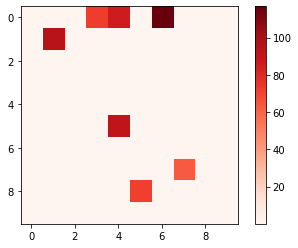

In [4]:
modulus = np.absolute(sky_image)
plt.imshow(modulus, cmap='Reds') 
cbar = plt.colorbar()

### 1.2 Fourier transform (frequency domain)

In [5]:
visibilities = np.fft.fft2(sky_image).astype('complex64')
print(visibilities)

[[ 480.04205  +316.29578j   -173.76476  -227.70288j
    98.98489    -2.3072073j  129.4568    -59.630203j
  -146.90222  -111.02941j     -5.7989984 -37.36861j
  -195.43446   -46.569134j    23.829382 +166.86057j
    40.75392   +67.20267j   -251.4373    -66.309326j ]
 [ 202.36772  +122.63828j    -81.447174 -213.16829j
   155.02655   -90.45889j   -110.496     +34.056103j
  -120.724556  -88.93913j     59.350582 -144.71437j
  -292.4528   +307.1357j     188.5591    -39.662758j
   -71.348114  +82.61835j     71.06712   +30.3993j   ]
 [ 276.40793   +55.62675j     -6.6169515-289.50238j
  -145.78905   +47.715656j    44.095478   -9.345417j
  -250.31015  -153.67871j    197.92332  +223.67061j
  -362.52744   +15.306438j   268.7384   +117.24948j
   126.23911   +17.042788j  -148.08467   -23.678745j ]
 [ 249.72449  -122.845474j  -206.68141   +20.667784j
   -50.12668  -224.16434j    -93.952065 +174.90208j
   -36.931713  -11.8482485j   12.170324 +100.919525j
  -167.58414   +73.45047j    393.71768   +94.0179

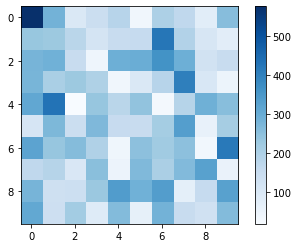

In [6]:
modulus = np.absolute(visibilities)
plt.imshow(modulus, cmap='Blues')
plt.colorbar();

#### * Sanity check

In [7]:
img = np.fft.ifft2(visibilities).astype('complex64')

test_real = ((sky_image.real - img.real)**2).mean()
test_imag = ((sky_image.imag - img.imag)**2).mean()
 
print('Reals MSE: '+ str(test_real))
print('Imaginaries MSE: '+ str(test_imag))

Reals MSE: 1.384676e-13
Imaginaries MSE: 2.0142006e-13


## 2. Data embedding (calibration step)

### 2.1 data pre-processing
### 2.2 data encoding

In [8]:
# encoding binary data onto qubits
def binary_encode(qc, binary, off_set):
    
    for i in range(0, len(binary)):
        qc.reset(off_set+i) # set quantum state |0> by default for all qubits

        if binary[i]=='1':
            qc.x(off_set+i) # act as a CX (controlled X gate)
    
    off_set += len(binary)

    return off_set

In [9]:
number_of_entries = visibilities.shape[0] * visibilities.shape[1]
number_of_bits_real = 32
number_of_bits_imag = 32
number_of_bits = number_of_bits_real + number_of_bits_imag
off_set = 0

# encoding (n bits encoded onto n qubits)
qc = QuantumCircuit(number_of_entries*number_of_bits)
for i in range(0, visibilities.shape[0]):
    for j in range(0, visibilities.shape[1]):
            binary_real = float_to_bin_real(visibilities[i, j].real)
            binary_imag = float_to_bin_imag(visibilities[i, j].imag)
            binary = binary_real+binary_imag
            off_set = binary_encode(qc, binary, off_set)

## 3. Data reading

### 3.1 readout

In [10]:
# measurement
qc.measure_all()
backend = Aer.get_backend('aer_simulator') # Qiskit's staple simulator (CHOICE MOTIVATION?)
job = backend.run(qc, shots=1, memory=True) 
output = job.result().get_memory()[0]
out = reverse(output)

# readout
chunks_real = []
chunks_imag = []
for i in range(0, number_of_entries):
    chunks_real.append(out[number_of_bits*i:(number_of_bits*i)+number_of_bits_real]) # real parts represented every 64 bits starting from the first one
    chunks_imag.append(out[(number_of_bits*i)+number_of_bits_imag:(number_of_bits*i)+number_of_bits_imag+number_of_bits_imag]) # imaginary parts represented every 64 bits starting after the first occurence of a real part 

readout = []
for i in range(0, len(chunks_real)):
    readout.append(complex(bin_to_float_real(chunks_real[i]), bin_to_float_imag(chunks_imag[i]))) 

readout = np.array(readout).reshape(n , n).astype('complex64')
print(readout)

[[ 480.04205  +316.29578j   -173.76476  -227.70288j
    98.98489    -2.3072073j  129.4568    -59.630203j
  -146.90222  -111.02941j     -5.7989984 -37.36861j
  -195.43446   -46.569134j    23.829382 +166.86057j
    40.75392   +67.20267j   -251.4373    -66.309326j ]
 [ 202.36772  +122.63828j    -81.447174 -213.16829j
   155.02655   -90.45889j   -110.496     +34.056103j
  -120.724556  -88.93913j     59.350582 -144.71437j
  -292.4528   +307.1357j     188.5591    -39.662758j
   -71.348114  +82.61835j     71.06712   +30.3993j   ]
 [ 276.40793   +55.62675j     -6.6169515-289.50238j
  -145.78905   +47.715656j    44.095478   -9.345417j
  -250.31015  -153.67871j    197.92332  +223.67061j
  -362.52744   +15.306438j   268.7384   +117.24948j
   126.23911   +17.042788j  -148.08467   -23.678745j ]
 [ 249.72449  -122.845474j  -206.68141   +20.667784j
   -50.12668  -224.16434j    -93.952065 +174.90208j
   -36.931713  -11.8482485j   12.170324 +100.919525j
  -167.58414   +73.45047j    393.71768   +94.0179

### 3.2 inverse Fourier transform (spatial domain)

In [11]:
img = np.fft.ifft2(readout).astype('complex64')

#### fidelity test

In [12]:
test_real = ((sky_image.real - img.real)**2).mean()
test_imag = ((sky_image.imag - img.imag)**2).mean()

print('Reals MSE: '+ str(test_real))
print('Imaginaries MSE: '+ str(test_imag))

Reals MSE: 1.384676e-13
Imaginaries MSE: 2.0142006e-13


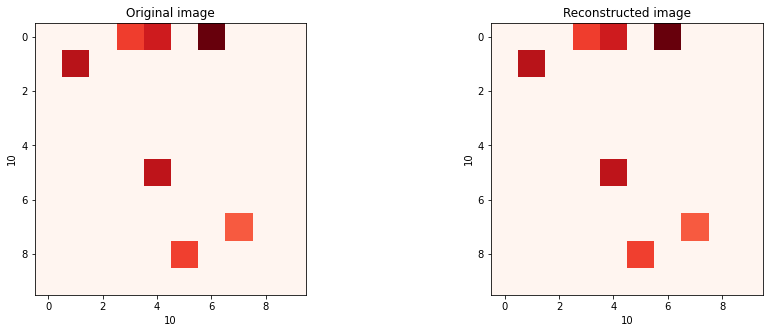

In [13]:
fig, axs = plt.subplots(1, 2, figsize=(15,5))
modulus1 = np.absolute(sky_image)
modulus2 = np.absolute(img)

axs[0].imshow(modulus1, cmap='Reds')
axs[1].imshow(modulus2, cmap='Reds')

axs[0].set_title("Original image")
axs[1].set_title("Reconstructed image")

for ax in axs.flat:
    ax.set(xlabel=n, ylabel=n)